# Пример использования библиотеки BigARTM для тематического моделирования
## Для Bigartm v0.8.0
### Редактировал Максим Чурилин

Импортируем BigARTM:

In [1]:
# -*- coding: utf-8 -*-
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import artm

Первое считывание данных (преобразуем удобный для человека формат в формат, который использует модель):

In [3]:
batch_vectorizer = artm.BatchVectorizer(data_path="school.txt", data_format="vowpal_wabbit", target_folder="school_batches", 
                                       batch_size=100, )

В следующий раз данные можно считывать уже из батчей:

In [4]:
batch_vectorizer = artm.BatchVectorizer(data_path="school_batches", data_format='batches')

Создаем объект модели:

In [5]:
T = 10   # количество тем
model_artm = artm.ARTM(num_topics=T, topic_names=["sbj"+str(i) for i in range(T)], class_ids={"text":1}, 
                       num_document_passes=1, reuse_theta=True, cache_theta=True, seed=-1)
# число после названия модальностей - это их веса

Создаем словарь и инициализируем модель с его помощью

In [6]:
dictionary = artm.Dictionary('dictionary')
dictionary.gather(batch_vectorizer.data_path)

In [7]:
model_artm.scores.add(artm.PerplexityScore(name='PerplexityScore',
                                           dictionary='dictionary'))
model_artm.scores.add(artm.SparsityPhiScore(name='SparsityPhiScore', class_id="text"))
model_artm.scores.add(artm.SparsityThetaScore(name='SparsityThetaScore'))
model_artm.scores.add(artm.TopTokensScore(name="top_words", num_tokens=15, class_id="text"))

In [8]:
model_artm.initialize('dictionary')

Строим модель. Offline - проходит по всей коллекции много раз. Удобно, когда коллекция маленькая.

In [9]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=40)

Необходимое число итераций можно отслеживать по графику перплексии. Когда она перестала меняться, модель сошлась.

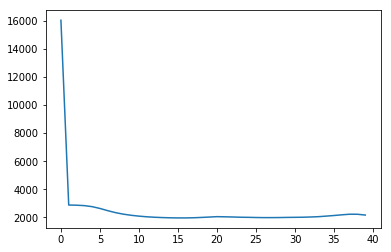

In [10]:
plt.plot(model_artm.score_tracker["PerplexityScore"].value)

Выведем топы слов:

In [11]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  который быть что это человек этот как свой для они его весь такой время себя
sbj1:  a множитель возведение b скобка x раскладывать умножение сокращенный разложение ответ квадрат слагаемое многочлен выражение
sbj2:  обособление куприн слово раскольников мастер роман словосочетание маргарита подчинительный соня оборот вера браслет старик сантьяго
sbj3:  который быть год свой время государство человек мир становиться жизнь северный первый война африка ребенок
sbj4:  x a b уравнение дробь квадратный y степень функция число f решение корень c пример
sbj5:  быть год пушкин функция свой его русский который поэт империя культура весь a f трение
sbj6:  сила быть тело энергия поле при магнитный точка географический наречие если частица например заряд величина
sbj7:  который что это как человек для этот такой быть являться мочь себя она его свой
sbj8:  который быть что это свой как этот человек для x они такой государство a весь
sbj9:  который быть что этот это как человек свой для такой в

Давайте посмотрим также на разреженность матриц:

In [12]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.733318865299
0.16533613205


В темах много общеупотребительных слов (так называемой, фоновой лексики). Чтобы этого избежать, будем использовать разреживающий регуляризатор для матрицы фи. Он будет подавлять слова, которые имеют большую частоту во всей коллекции.

In [13]:
model_artm.regularizers.add(artm.SmoothSparsePhiRegularizer(name='SparsePhi', tau=-100, dictionary=dictionary))
#если вы хотите применять регуляризатор только к некоторым модальностям, указывайте это в параметре class_ids: class_ids=["text"]

In [14]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [15]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  который быть что это этот как человек свой для они весь такой его время год
sbj1: 

KeyError: u'sbj1'

In [25]:
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

0.816808521748
0.302521020174


Попробуем менять коэффициент регуляризации:

In [26]:
model_artm.regularizers['SparsePhi'].tau = -5*1e4

In [27]:
model_artm.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=15)

In [28]:
for topic_name in model_artm.topic_names:
    print topic_name + ': ',
    tokens = model_artm.score_tracker["top_words"].last_tokens
    for word in tokens[topic_name]:    
        print word,
    print

sbj0:  предложение вода корень древний квадратный дом n океан жить собственный крестьянин член александр зона достигать
sbj1: 

KeyError: u'sbj1'

In [29]:
# еще раз посмотрим на разреженность
print model_artm.score_tracker["SparsityPhiScore"].last_value
print model_artm.score_tracker["SparsityThetaScore"].last_value

 0.910509943962
0.484873950481


Обратите внимание, что разреживать модель рекомендуется только после того, как она сошлась без регуляризации.

Сохранение и загрузка модели:

In [30]:
model_artm.save("my_model")

In [31]:
model_artm.load("my_model")

Можно попросить матрицы в чистом виде:

In [32]:
phi = model_artm.get_phi()

In [33]:
phi

,sbj0,sbj1,sbj2,sbj3,sbj4,sbj5,sbj6,sbj7,sbj8,sbj9
Бессольцевой,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
проучивать,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
допрос,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
прогуливать,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
сомов,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
ведомый,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
отстранение,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
внучка,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000101,0.000000
ученица,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000
ЧучелоВ,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000050,0.000000


Матрица вероятностей тем в документах.

In [34]:
theta = model_artm.get_theta()
theta

,200,201,202,203,204,205,206,207,208,209,...,390,391,392,393,394,395,396,397,398,399
sbj0,0.032051,0.052632,0.093117,0.025000,0.011765,0.008811,0.042169,0.0300,0.047751,0.072848,...,0.301038,0.217631,0.335009,0.438202,0.448996,0.545729,0.381868,0.198473,0.234286,0.477607
sbj1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj3,0.009615,0.000000,0.000000,0.066667,0.000000,0.000000,0.021084,0.0175,0.185856,0.016556,...,0.006920,0.024793,0.037288,0.011236,0.024465,0.013863,0.030220,0.041985,0.000000,0.099707
sbj4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.027682,0.008264,0.017534,0.028090,0.015291,0.072762,0.005495,0.057252,0.051429,0.049853
sbj6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
sbj7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.003460,0.011019,0.027119,0.028090,0.015291,0.011765,0.000000,0.015267,0.011429,0.011730
sbj8,0.080128,0.473684,0.275304,0.054167,0.290196,0.202643,0.045181,0.0325,0.090164,0.069536,...,0.076125,0.088154,0.115254,0.050562,0.055591,0.032353,0.101648,0.091603,0.222857,0.070781
sbj9,0.878205,0.473684,0.631579,0.854167,0.698039,0.788546,0.891566,0.9200,0.676230,0.841060,...,0.584775,0.650138,0.467796,0.443820,0.440367,0.323529,0.480769,0.595420,0.480000,0.290322


Если бы у нас были новые батчи, по которым мы не строим модель, а хотим только получить матрицу theta, можно пользоваться методом transform.

In [36]:
theta_test = model_artm.transform(batch_vectorizer)